# Color and gradients pipeline

In this notebook I'll explain the pipeline applied to the image in order to detect lanes

In [2]:
root_folder = '../'

import sys 
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

sys.path.append(root_folder + 'src/')

from camera import camera
from gradient import gradient

%matplotlib inline

cam = camera(root_folder + 'camera_cal/calibration*.jpg')

# Call calibration function
cam.calibrate()

True

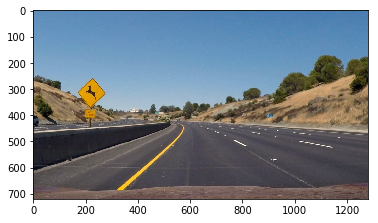

In [8]:
# Load image
img = mpimg.imread(root_folder + 'test_images/test2.jpg')
plt.imshow(img)


## Analyse image channels

255


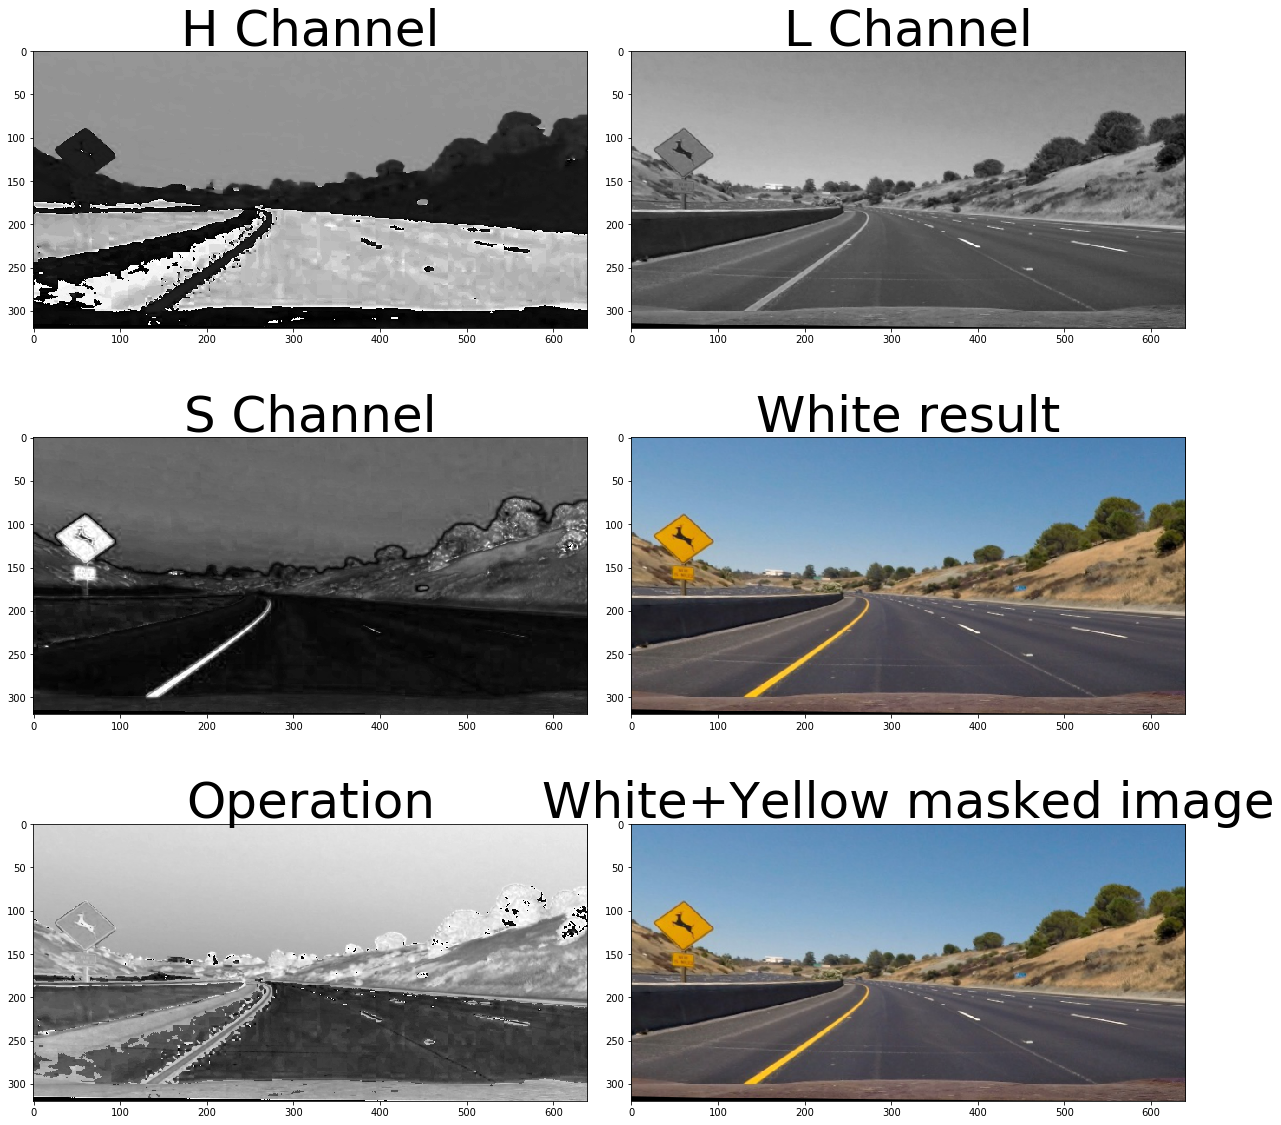

In [9]:
# Load image
img = mpimg.imread(root_folder + 'examples/original.jpg')
# img = mpimg.imread(root_folder + 'test_images/challenge_test2.jpg')

# Undistort the image
undist = cam.undistort(img)
# cv2.imwrite(root_folder + 'examples/undistorted.jpg', cv2.cvtColor(cv2.resize(undist, (640,320)), cv2.COLOR_BGR2RGB))


# Convert to HLS color space
hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)

yellowMask = cv2.inRange(hls ,(20, 100, 0),(25,150,200))
whiteMask = cv2.inRange(hls ,(0, 0, 0),(255,255,255))

yellowRes = cv2.bitwise_and(undist, undist, mask= yellowMask)
whiteRes = cv2.bitwise_and(undist, undist, mask= whiteMask)

print(np.max(yellowMask))

mask = np.zeros_like(yellowMask)
mask[(yellowMask != 0) | (whiteMask != 0)  ] = 1

res = cv2.bitwise_and(undist, undist, mask= mask)

contrast = 1.0
brightness = 0

# h_channel = np.uint8(np.clip(contrast*hls[:,:,0] + brightness, 0, 255))
# l_channel = np.uint8(np.clip(0.5*hls[:,:,1] - 20, 0, 255))
# s_channel = np.uint8(np.clip(1.0*hls[:,:,2] + brightness, 0, 255))

h_channel = hls[:,:,0]
l_channel = hls[:,:,1]
s_channel = hls[:,:,2]

# Save images
# cv2.imwrite(root_folder + 'examples/l_channel.jpg', cv2.cvtColor(cv2.resize(l_channel, (640,320)), cv2.COLOR_GRAY2RGB))
# cv2.imwrite(root_folder + 'examples/s_channel.jpg', cv2.cvtColor(cv2.resize(s_channel, (640,320)), cv2.COLOR_GRAY2RGB))


result = np.clip(h_channel - l_channel, 0, 255)

# Show original and color channels
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 9))
f.tight_layout()
ax1.imshow(h_channel, cmap="gray")
ax1.set_title('H Channel', fontsize=50)

ax2.imshow(l_channel, cmap='gray')
ax2.set_title('L Channel', fontsize=50)

ax3.imshow(s_channel, cmap='gray')
ax3.set_title('S Channel', fontsize=50)

ax4.imshow(whiteRes, cmap='gray')
ax4.set_title('White result', fontsize=50)

ax5.imshow(result, cmap="gray")
ax5.set_title('Operation', fontsize=50)

ax6.imshow(res)
ax6.set_title('White+Yellow masked image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

color_h = np.dstack(( hls[:,:,0], np.zeros_like(hls[:,:,0]), np.zeros_like(hls[:,:,2]))) 
# cv2.imwrite(root_folder + "examples/channel_h.jpg", cv2.cvtColor(color_h, cv2.COLOR_RGB2BGR))

color_l = np.dstack(( hls[:,:,1], np.zeros_like(hls[:,:,1]), np.zeros_like(hls[:,:,2]))) 
# cv2.imwrite(root_folder + "examples/channel_l.jpg", cv2.cvtColor(color_l, cv2.COLOR_RGB2BGR))

color_s = np.dstack(( hls[:,:,2], np.zeros_like(hls[:,:,2]), np.zeros_like(hls[:,:,2]))) 
# cv2.imwrite(root_folder + "examples/channel_s.jpg", cv2.cvtColor(color_s, cv2.COLOR_RGB2BGR))


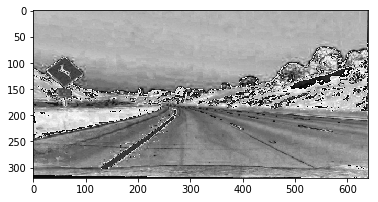

In [10]:
def brightness_contract(image, contrast, brightness):
    assert contrast >=1.0 and contrast <= 3.0
    assert brightness >=0 and contrast <= 100
    
    new_image = np.zeros(image.shape, image.dtype)
    
    for y in range(image.shape[0]):
        for x in range(image.shape[1]):
            if(len(image.shape) > 2):
                for c in range(image.shape[2]):
                    new_image[y,x,c] = np.clip(contrast*image[y,x,c] + brightness, 0, 255)
            else:
                new_image[y,x] = np.clip(contrast*image[y,x] + brightness, 0, 255)
    
    return new_image

h_high = brightness_contract(h_channel, 2, 10)
l_high = brightness_contract(l_channel, 2, 10)
s_high = brightness_contract(s_channel, 2, 10)

result = np.clip(s_high + h_high - l_high, 0, 255)

plt.imshow(result, cmap="gray")

## Absolute sobel threshold filter

The sobel filter allow me to detect edges, in fact this process is also used in the canny alghorithm.

This function accept a one channel image and can apply sobel in x and y directions

In [11]:
def abs_sobel_threshold(channel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude
    binary_output = np.zeros_like(scaled_sobel)

    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output

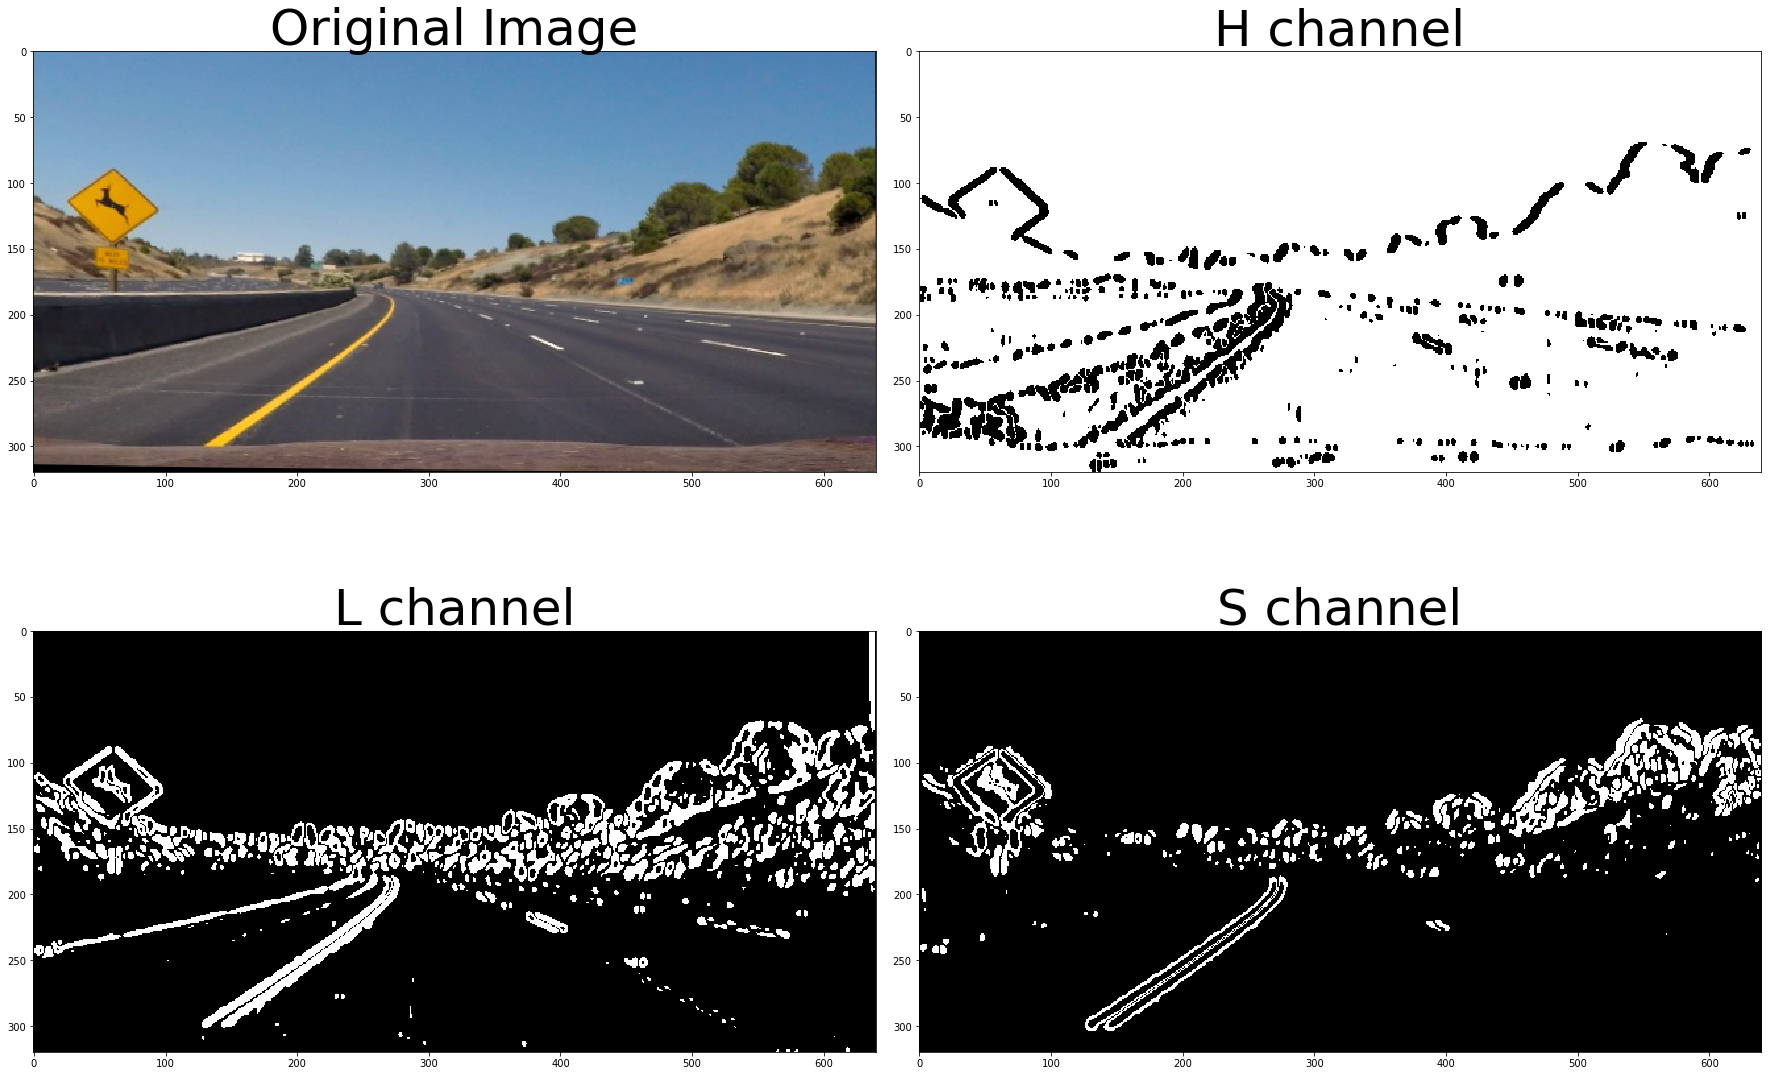

In [12]:

# Sobel x on each channel

treshold = (20, 100)
h_treshold = (0, 20)
ksize = 15

h_solbel_x = abs_sobel_threshold(hls[:,:,0], orient='x', sobel_kernel=ksize, thresh=h_treshold)
l_solbel_x = abs_sobel_threshold(hls[:,:,1], orient='x', sobel_kernel=ksize, thresh=treshold)
s_solbel_x = abs_sobel_threshold(hls[:,:,2], orient='x', sobel_kernel=ksize, thresh=treshold)

# Show original and warped image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(h_solbel_x, cmap='gray')
ax2.set_title('H channel', fontsize=50)

ax3.imshow(l_solbel_x, cmap='gray')
ax3.set_title('L channel', fontsize=50)

ax4.imshow(s_solbel_x, cmap='gray')
ax4.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

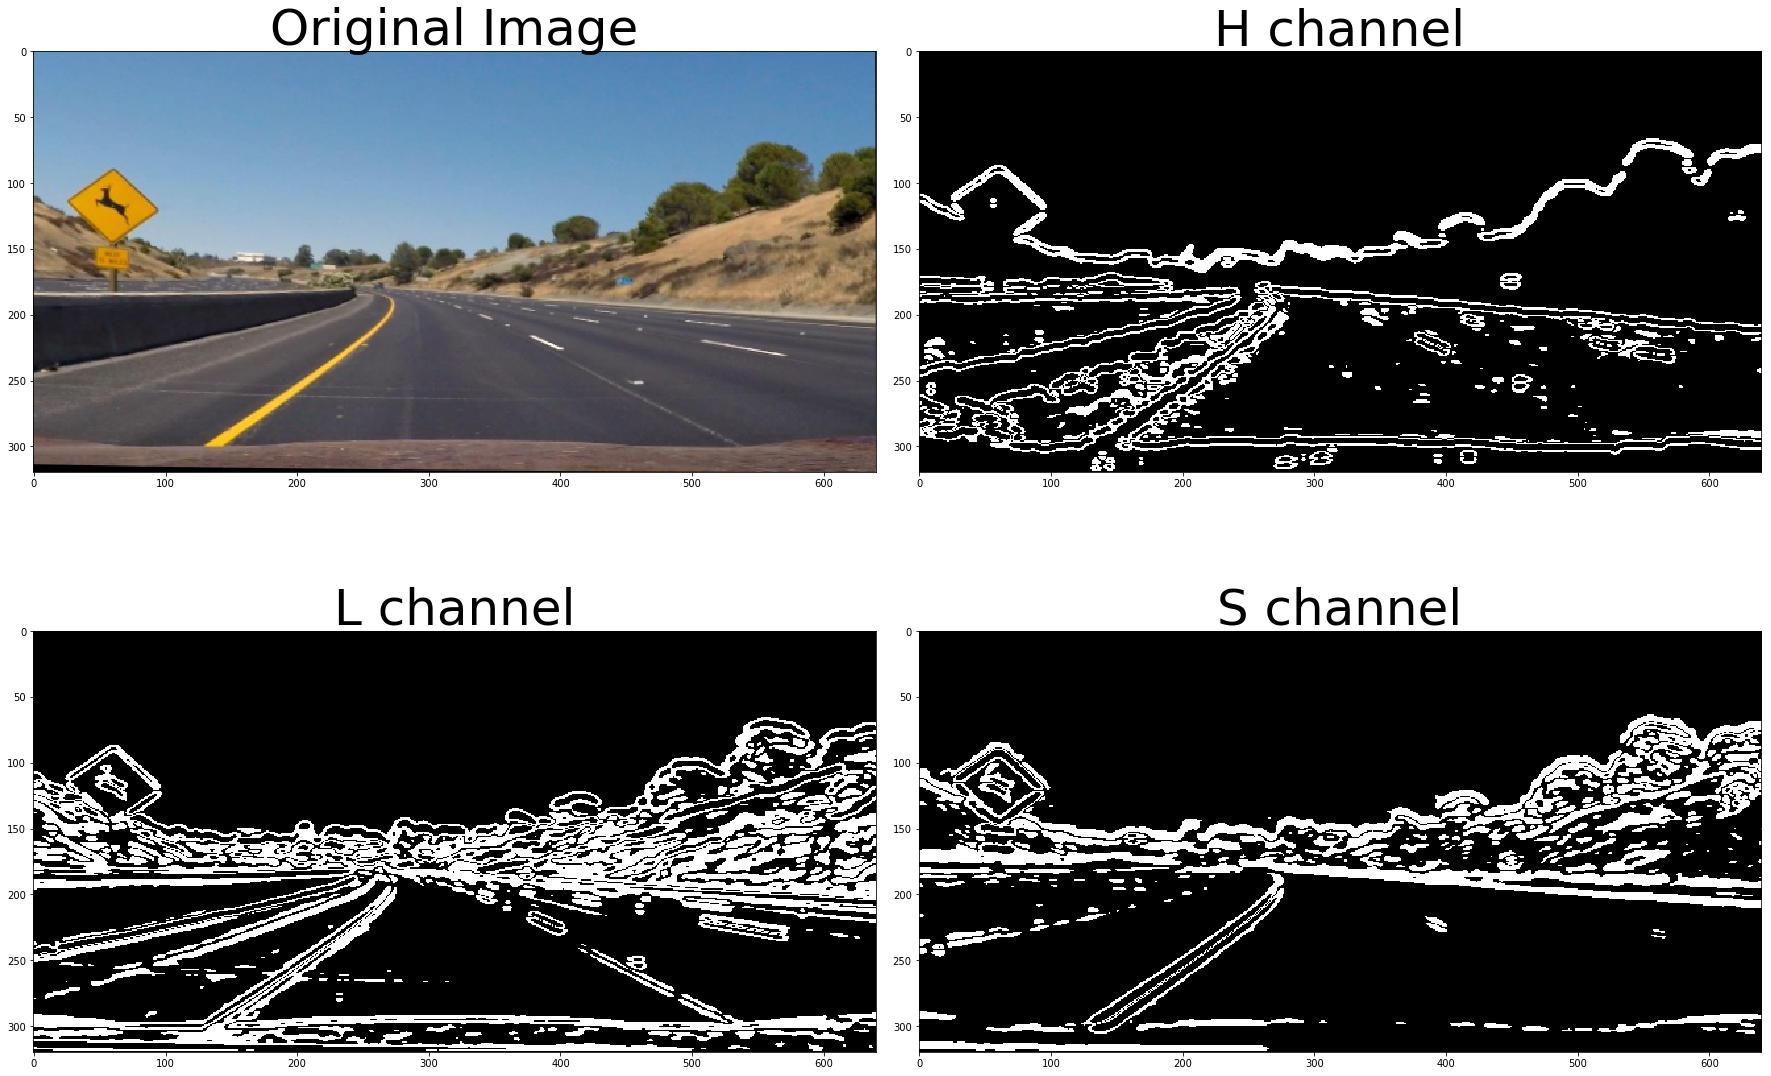

In [13]:
# Sobel y on each channel

treshold = (20, 100)
ksize = 15

h_solbel_y = abs_sobel_threshold(hls[:,:,0], orient='y', sobel_kernel=ksize, thresh=treshold)
l_solbel_y = abs_sobel_threshold(hls[:,:,1], orient='y', sobel_kernel=ksize, thresh=treshold)
s_solbel_y = abs_sobel_threshold(hls[:,:,2], orient='y', sobel_kernel=ksize, thresh=treshold)

# Show original and warped image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(h_solbel_y, cmap='gray')
ax2.set_title('H channel', fontsize=50)

ax3.imshow(l_solbel_y, cmap='gray')
ax3.set_title('L channel', fontsize=50)

ax4.imshow(s_solbel_y, cmap='gray')
ax4.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

## Magnitude treshold filter

This function is based on sobel filter and calculate the magnitude of every pixel edge using sobel x and sobel y

In [14]:
def mag_threshold(channel, sobel_kernel=3, thresh=(0, 255)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    abs_sobel_xy = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel_xy/np.max(abs_sobel_xy))
    
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

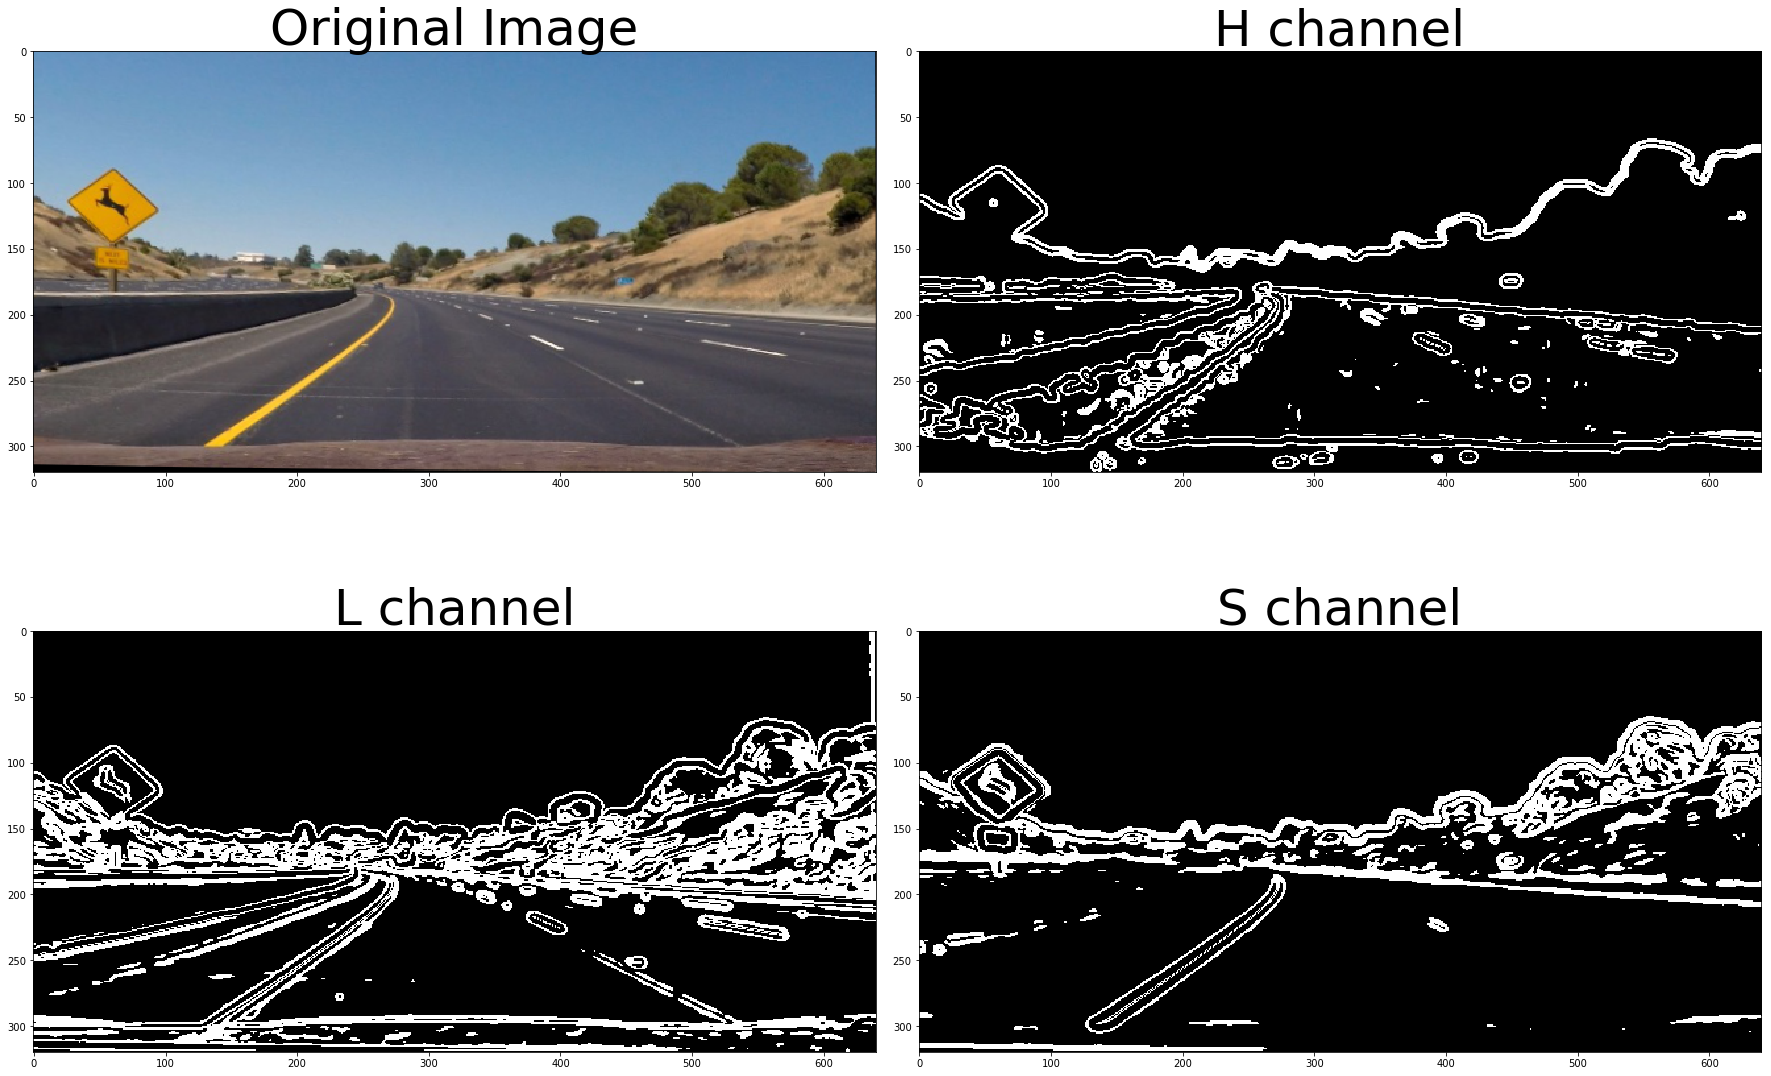

In [15]:
# Magnitude x on each channel

treshold = (25, 100)
ksize = 15

h_mag = mag_threshold(hls[:,:,0], sobel_kernel=ksize, thresh=treshold)
l_mag = mag_threshold(hls[:,:,1], sobel_kernel=ksize, thresh=treshold)
s_mag = mag_threshold(hls[:,:,2], sobel_kernel=ksize, thresh=treshold)

# Show original and warped image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(h_mag, cmap='gray')
ax2.set_title('H channel', fontsize=50)

ax3.imshow(l_mag, cmap='gray')
ax3.set_title('L channel', fontsize=50)

ax4.imshow(s_mag, cmap='gray')
ax4.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

## Direction treshold filter

This function is based on sobel filter and calculate the direction of every pixel edge using sobel x and sobel y

In [16]:
def dir_threshold(channel, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gradient_direction)
    binary_output[(gradient_direction>= thresh[0]) & (gradient_direction <=thresh[1])] = 1

    # Return this mask as your binary_output image
    return binary_output

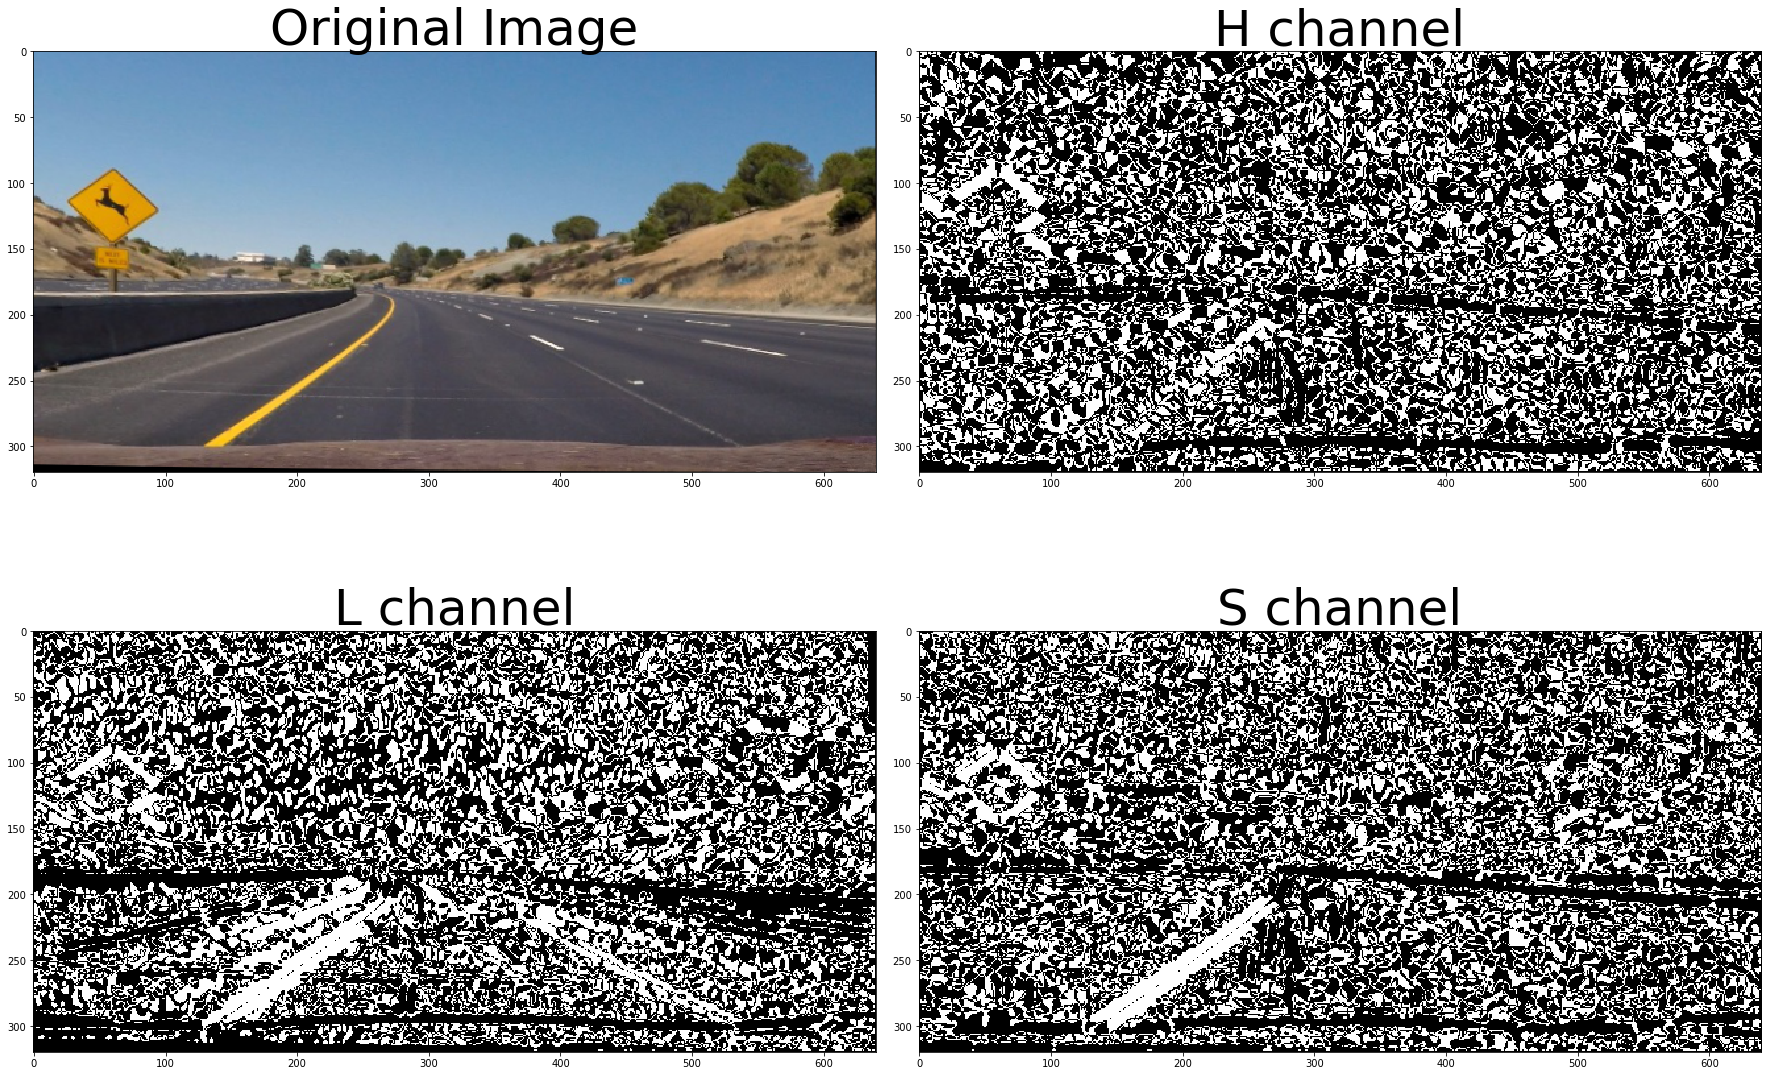

In [17]:
# Direction x on each channel

treshold = (0.7, 1.3)
ksize = 15

h_dir = dir_threshold(hls[:,:,0], sobel_kernel=ksize, thresh=treshold)
l_dir = dir_threshold(hls[:,:,1], sobel_kernel=ksize, thresh=treshold)
s_dir = dir_threshold(hls[:,:,2], sobel_kernel=ksize, thresh=treshold)

# Show original and warped image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(h_dir, cmap='gray')
ax2.set_title('H channel', fontsize=50)

ax3.imshow(l_dir, cmap='gray')
ax3.set_title('L channel', fontsize=50)

ax4.imshow(s_dir, cmap='gray')
ax4.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

True

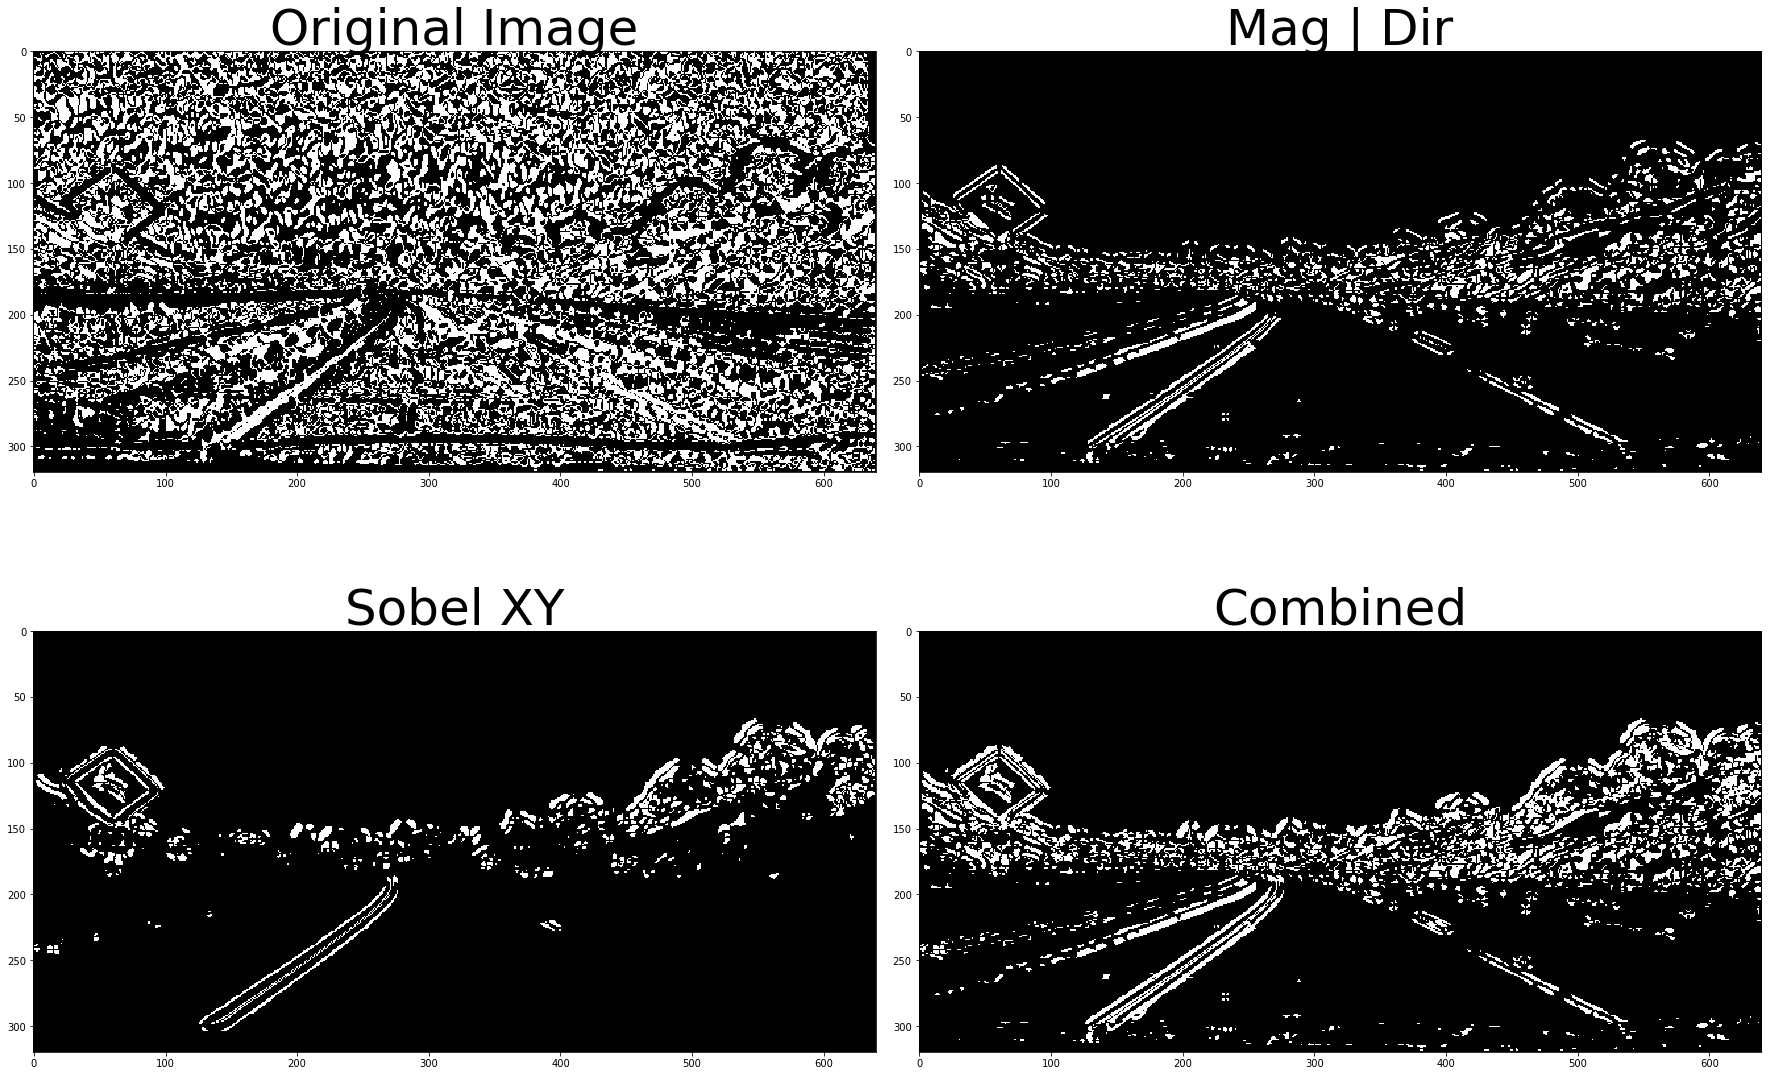

In [26]:
# Test1
mag_dir = np.zeros_like(h_solbel_x)
sob_x_dir = np.zeros_like(h_solbel_x)
sobel_xy = np.zeros_like(h_solbel_x)
combined = np.zeros_like(h_solbel_x)

# Combine results
sobel_xy[((s_solbel_x == 1) & (s_solbel_y == 1))] = 1

mag_dir[((l_mag == 1) & (l_dir == 1))] = 1

sob_x_dir[((h_solbel_x == 1) & (l_dir == 1))] = 1

combined[((sobel_xy == 1) | (mag_dir ==1))] = 1

# Show original and warped image
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sob_x_dir, cmap='gray')
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(mag_dir, cmap='gray')
ax2.set_title('Mag | Dir', fontsize=50)


ax3.imshow(sobel_xy, cmap='gray')
ax3.set_title('Sobel XY', fontsize=50)


ax4.imshow(combined, cmap='gray')
ax4.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

# Save images
# mag_dir[mag_dir == 1] = 255 
# cv2.imwrite(root_folder + 'examples/mag_dir_filter.jpg', cv2.cvtColor(cv2.resize(mag_dir, (640,320)), cv2.COLOR_GRAY2RGB))

# sobel_xy[sobel_xy == 1] = 255 
# cv2.imwrite(root_folder + 'examples/sobel_filter.jpg', cv2.cvtColor(cv2.resize(sobel_xy, (640,320)), cv2.COLOR_GRAY2RGB))

# combined[combined == 1] = 255 
# cv2.imwrite(root_folder + 'examples/full_binary.jpg', cv2.cvtColor(cv2.resize(combined, (640,320)), cv2.COLOR_GRAY2RGB))


# Pipeline

here is the pipeline:

- Convert the image to HLS color space and extract the S channel
- Apply on the channel Sobel, Magnitude, Direction functions 
- Use three binary output to compute the result binary

If the kernel size is too large the sobel filter may cut some parts of the lanes this is why i chose to catch pixels also by magnitude and direction


In [20]:
def pipeline(img, ksize=3, d_thresh=(0.7, 1.3),  m_thresh=(30, 100), sx_thresh=(20, 100), sy_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    
    ksize=15
    
    # Sobel 
    sxbinary = abs_sobel_threshold(s_channel, orient='x', sobel_kernel=5, thresh=sx_thresh)
    sybinary = abs_sobel_threshold(s_channel, orient='y', sobel_kernel=5, thresh=sy_thresh)
    
    # Magnitude 
    mxbinary = mag_threshold(l_channel, sobel_kernel=ksize, thresh=m_thresh)
    
    # Direction 
    dxbinary = dir_threshold(l_channel, sobel_kernel=ksize)

    # For tests: Stack each filter
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, mxbinary)) * 255

    combined = np.zeros_like(sxbinary)
    
    # Combine results
    combined[((sxbinary == 1) & (sybinary == 1)) | ((mxbinary == 1) & (dxbinary == 1))] = 1

    return combined
    

### Try on an image

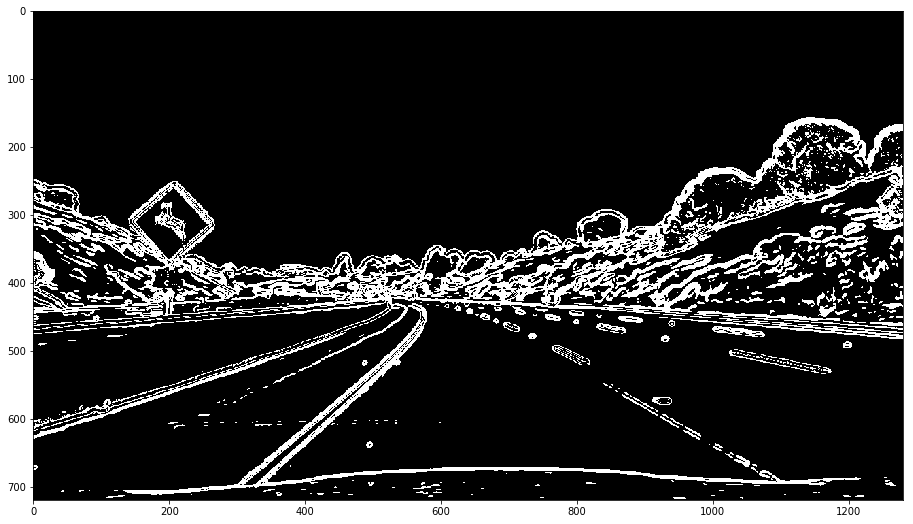

In [21]:
# import test image
test1 = mpimg.imread(root_folder + 'test_images/test2.jpg')


# Undistort the image
test1 = cam.undistort(test1)

kernel_size = 3

result = pipeline(test1, ksize=kernel_size)

plt.figure(figsize = (16,9))
plt.imshow(result, cmap='gray')

## Try the pipeline on a birds eyed image

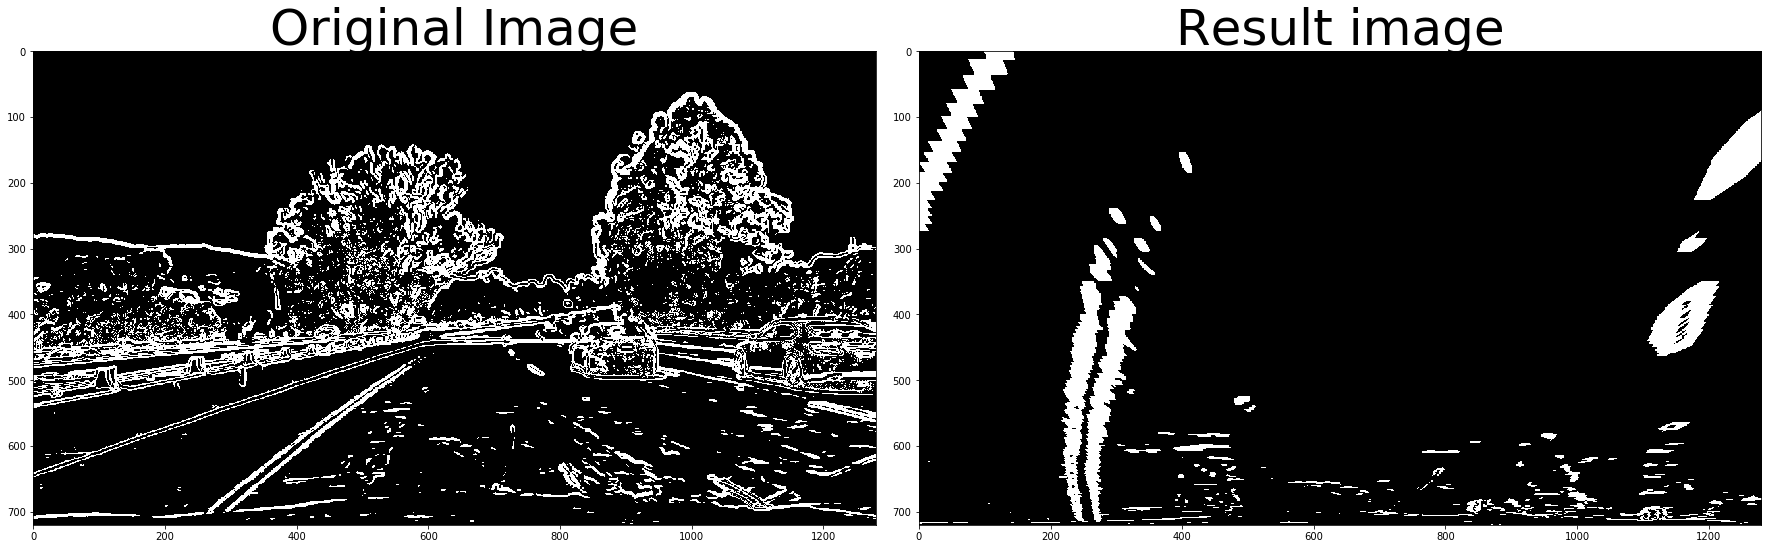

In [22]:
# import test image
test1 = mpimg.imread(root_folder + 'examples/original.jpg')

# Undistort the image
test1 = cam.undistort(test1)

test1 = pipeline(test1)

# Transform to bird's eye view
result = cam.birdsEyeTranform(test1)

# Show original and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(result, cmap='gray')
ax2.set_title('Result image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Try gradient class

In this section it's possibile to tune gradient class for the best lane detection

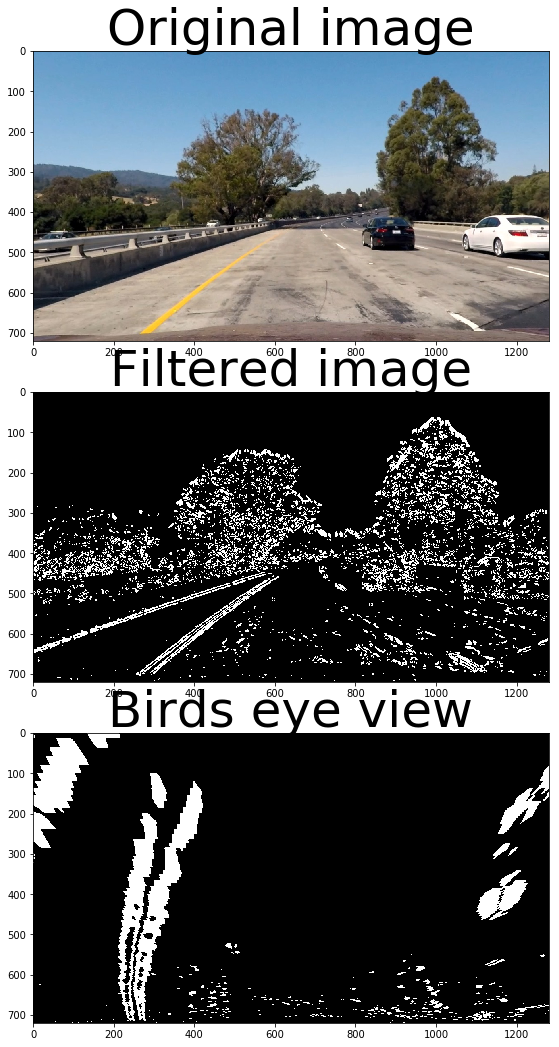

In [31]:
grad = gradient(
    direction=(1, 25, 0.7, 1.3),  
    magnitude=(1, 25, 25, 150), 
    sobelx=(2, 15, 20, 100), 
    sobely=(2, 15, 20, 100))

# import test image
test1 = mpimg.imread(root_folder + 'examples/original.jpg')

# Undistort the image
undist = cam.undistort(test1)

pipeline = grad.executePipeline(undist)

# Transform to bird's eye view
result = cam.birdsEyeTranform(pipeline)

# Show original and warped image
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 9))
f.tight_layout()
ax1.imshow(undist, cmap='gray')
ax1.set_title('Original image', fontsize=50)

ax2.imshow(pipeline, cmap='gray')
ax2.set_title('Filtered image', fontsize=50)

ax3.imshow(result, cmap='gray')
ax3.set_title('Birds eye view', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=1.5, bottom=0)